In [1]:
import multiprocessing
import os
import warnings
from copy import deepcopy
from typing import Union

import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap 
from gensim.models import Word2Vec
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

plt.style.use("seaborn")

In [3]:
warnings.filterwarnings("ignore")

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Task

Данные взяты [тут](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview).

Можете мерять результат по 5-fold evaluation на train-set,  per user auc roc.  

**Задача 1:**

Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

**Задача 2:**

Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

- показать симилары глазами

- в качестве рекоммендера вместо GBDT (разницу в метриках) 

- стек с GBDT (прирост / отсутствие / почему / SHAP values)


# Data preprocessing

In [5]:
data_path = "./data"

train = pd.read_csv(os.path.join(data_path, "train.csv"))
songs = pd.read_csv(os.path.join(data_path, "songs.csv"))
members = pd.read_csv(os.path.join(data_path, "members.csv"),
                      parse_dates=["registration_init_time", "expiration_date"])
song_extra_info = pd.read_csv(os.path.join(data_path, "song_extra_info.csv"))

In [6]:
def print_stat(df: pd.DataFrame):
    print(f"DataFrame shape: {df.shape}")
    
    warning, bold, end = "\033[93m", "\033[1m", "\033[0m"
    format_len = max(map(len, df.columns)) + 1
        
    for column in df.columns:
        na_ratio = df[column].isna().sum() / df.shape[0]
        if na_ratio >= 0.4:
            print(f"{warning}{bold}\tColumn: {column:>{format_len}}, NA ratio: {round(na_ratio, 3)}{end}")
        else:
            print(f"\tColumn: {column:>{format_len}}, NA ratio: {round(na_ratio, 3)}")

## Посмотрим на train

In [7]:
print_stat(train)

DataFrame shape: (7377418, 6)
	Column:                msno, NA ratio: 0.0
	Column:             song_id, NA ratio: 0.0
	Column:   source_system_tab, NA ratio: 0.003
	Column:  source_screen_name, NA ratio: 0.056
	Column:         source_type, NA ratio: 0.003
	Column:              target, NA ratio: 0.0


С точки зрения `NA` значений в `train` нет ничего криминального, число пропусков не превышает `6%` в каждом признаке.

## Посмотрим на songs, members и song_extra_info

Добавим их в `train`.

### songs

In [8]:
print_stat(songs)

DataFrame shape: (2296320, 7)
	Column:      song_id, NA ratio: 0.0
	Column:  song_length, NA ratio: 0.0
	Column:    genre_ids, NA ratio: 0.041
	Column:  artist_name, NA ratio: 0.0
	Column:     composer, NA ratio: 0.467
	Column:     lyricist, NA ratio: 0.847
	Column:     language, NA ratio: 0.0


Так как столбцы `composer` и `lyricist` содержат больше `45%` пропусков, то удалим их. Оставшиеся данные присоединим к `train`.

In [9]:
songs = songs.drop(columns=["composer", "lyricist"], axis=1)

In [10]:
train = train.merge(songs, on="song_id", how="left")

In [11]:
train['song_length'].isna().sum()

114

Заполним пропуски в столбце `song_length` на среднее значение по столбцу.

In [12]:
train['song_length'].fillna((train['song_length'].mean()), inplace=True)

### members

In [13]:
print_stat(members)

DataFrame shape: (34403, 7)
	Column:                    msno, NA ratio: 0.0
	Column:                    city, NA ratio: 0.0
	Column:                      bd, NA ratio: 0.0
	Column:                  gender, NA ratio: 0.578
	Column:          registered_via, NA ratio: 0.0
	Column:  registration_init_time, NA ratio: 0.0
	Column:         expiration_date, NA ratio: 0.0


Столбец `gender` содержит больше `57%` пропусков. Давайте в этот раз не будем удалять такой столбец, а заменим все пропуски на `non-binary`.

In [14]:
members["gender"] = members["gender"].fillna("non-binary")

Разобьем столбцы `registration_init_time` и `expiration_date` на год, месяц, день, а сами столбцы удалим.

In [15]:
members["registration_day"] = members["registration_init_time"].dt.day
members["registration_month"] = members["registration_init_time"].dt.month
members["registration_year"] = members["registration_init_time"].dt.year

members["expiration_day"] = members["expiration_date"].dt.day
members["expiration_month"] = members["expiration_date"].dt.month
members["expiration_year"] = members["expiration_date"].dt.year

members = members.drop(columns=['registration_init_time', 'expiration_date'], axis=1)

Присоединим `members` к `train`.

In [16]:
train = train.merge(members, on="msno", how="left")

### song_extra_info

In [17]:
print_stat(song_extra_info)

DataFrame shape: (2295971, 3)
	Column:  song_id, NA ratio: 0.0
	Column:     name, NA ratio: 0.0
	Column:     isrc, NA ratio: 0.059


Столбец `isrc` записан в формате [International Standard Recording Code](https://en.wikipedia.org/wiki/International_Standard_Recording_Code). Извлечем скрытую в нем информацию. 

In [18]:
def get_country_code(x: Union[str, float]) -> Union[str, float]:
    if isinstance(x, str):
        return x[:2]

    return np.nan


def get_year(x: Union[str, float]) -> float:
    if isinstance(x, str):
        year = int(x[5:7])
        if year > 17:
            return 1900 + year
        return 2000 + year

    return np.nan

In [19]:
song_extra_info["song_contry"] = song_extra_info["isrc"].apply(get_country_code)
song_extra_info['song_year'] = song_extra_info['isrc'].apply(get_year)

Присоединим `song_extra_info` к `train`.

In [20]:
train = train.merge(song_extra_info, on="song_id", how="left")

## Фичи счетчики

- число прослушанных песен
- популярность жанра
- популярность артиста

In [21]:
user_song = {k: v for k, v in train["msno"].value_counts().iteritems()}
genre_count = {k: v for k, v in train["genre_ids"].value_counts().iteritems()}
artist_count = {k: v for k, v in train["artist_name"].value_counts().iteritems()}

train["activity"] = train["msno"].apply(lambda x: user_song.get(x, 0))
train["genre_popularity"] = train["genre_ids"].apply(lambda x: genre_count.get(x, 0))
train["artist_popularity"] = train["artist_name"].apply(lambda x: artist_count.get(x, 0))

In [22]:
train.dtypes

msno                   object
song_id                object
source_system_tab      object
source_screen_name     object
source_type            object
target                  int64
song_length           float64
genre_ids              object
artist_name            object
language              float64
city                    int64
bd                      int64
gender                 object
registered_via          int64
registration_day        int64
registration_month      int64
registration_year       int64
expiration_day          int64
expiration_month        int64
expiration_year         int64
name                   object
isrc                   object
song_contry            object
song_year             float64
activity                int64
genre_popularity        int64
artist_popularity       int64
dtype: object

## Сохранение

In [23]:
categorical_columns = ["source_system_tab", "source_screen_name", "source_type", 
                       "genre_ids", "artist_name", "language", "city", "gender",
                       "registered_via", "name", "isrc", "song_contry"]

for column in categorical_columns:
    train[column] = train[column].astype("category")

In [24]:
train.to_csv("part_1.csv", index=False)

# Обучение GBDT

In [52]:
X, y = train.drop(columns=["msno", "song_id", "target"]), train["target"]

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [27]:
def create_model():
    return LGBMClassifier(
        num_leaves=30,
        max_depth=7,
        learning_rate=0.5,
        n_estimators=300,
        min_split_gain=1e-2,
        min_child_weight=2,
        subsample=9e-1,
        colsample_bytree=8e-1,
        reg_alpha=3e-1,
        reg_lambda=1e-1,
        verbose=-1
    )

In [28]:
def test(clf, encoder):
    X_train_transformed = encoder.fit_transform(X_train, y_train)
    X_val_transformed = encoder.transform(X_val)
    
    clf.fit(X=X_train_transformed, y=y_train, 
            eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)], 
            early_stopping_rounds=30, verbose=-1)
    
    y_pred = clf.predict_proba(X_val_transformed)[:, 1]
    
    print(f"ROC-AUC: {roc_auc_score(y_val, y_pred)}")

In [29]:
print_stat(X)

DataFrame shape: (7377418, 24)
	Column:   source_system_tab, NA ratio: 0.003
	Column:  source_screen_name, NA ratio: 0.056
	Column:         source_type, NA ratio: 0.003
	Column:         song_length, NA ratio: 0.0
	Column:           genre_ids, NA ratio: 0.016
	Column:         artist_name, NA ratio: 0.0
	Column:            language, NA ratio: 0.0
	Column:                city, NA ratio: 0.0
	Column:                  bd, NA ratio: 0.0
	Column:              gender, NA ratio: 0.0
	Column:      registered_via, NA ratio: 0.0
	Column:    registration_day, NA ratio: 0.0
	Column:  registration_month, NA ratio: 0.0
	Column:   registration_year, NA ratio: 0.0
	Column:      expiration_day, NA ratio: 0.0
	Column:    expiration_month, NA ratio: 0.0
	Column:     expiration_year, NA ratio: 0.0
	Column:                name, NA ratio: 0.0
	Column:                isrc, NA ratio: 0.078
	Column:         song_contry, NA ratio: 0.078
	Column:           song_year, NA ratio: 0.078
	Column:            activity, N

## Encoders

Протестируем различные `encoders`.

In [30]:
catboost_encoder = ce.CatBoostEncoder(cols=categorical_columns)
ordinal_encoder = ce.OrdinalEncoder(cols=categorical_columns)
james_encoder = ce.JamesSteinEncoder(cols=categorical_columns)

In [31]:
test(create_model(), catboost_encoder)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	training's binary_logloss: 0.592151	valid_1's binary_logloss: 0.594582
ROC-AUC: 0.7466239985499898


In [32]:
test(create_model(), ordinal_encoder)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	training's binary_logloss: 0.592321	valid_1's binary_logloss: 0.596168
ROC-AUC: 0.7448290894029963


In [33]:
test(create_model(), james_encoder)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.613951	valid_1's binary_logloss: 0.642567
ROC-AUC: 0.6846330172289958


Выберем `catboost_encoder`, так как с ним получились самые лучшие результаты.

## Подбор параметров

Используя `catboost_encoder`, подберем параметры. [Тут](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna.study.create_study) про `optuna`. Я порезал полотно вывода подбора параметров. Главное, что нужно знать: параметры, которые мы ищем, лежат в `study.best_params`.

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_transformed = catboost_encoder.fit_transform(X_train, y_train)
X_val_transformed = catboost_encoder.transform(X_val)

lgb_train = lgb.Dataset(X_train_transformed, y_train)
lgb_val = lgb.Dataset(X_val_transformed, y_val)

def objective(trial):
    params = {
        "num_leaves": 256,
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, step = 0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5, step = 0.1),
        "lambda_l2": trial.suggest_float('lambda_l2', 0, 5, step = 0.1),
        "verbosity": -1,
        "seed": 1
    }
    
    evals_result = {}
    
    lgb.train(params, 
              train_set=lgb_train,
              num_boost_round=100, 
              valid_sets = [lgb_train, lgb_val], 
              verbose_eval = 100,
              evals_result=evals_result)
    
    return np.max(evals_result["valid_1"]["auc"])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[100]	training's auc: 0.750508	valid_1's auc: 0.745674
[100]	training's auc: 0.728977	valid_1's auc: 0.72797
[100]	training's auc: 0.770159	valid_1's auc: 0.764055
[100]	training's auc: 0.750879	valid_1's auc: 0.747977
[100]	training's auc: 0.759027	valid_1's auc: 0.754038


Лучший результат получился при параметрах `study.best_params`. Во всех дальнейших экспериментах будем использовать их.

In [35]:
study.best_params

{'learning_rate': 0.27, 'max_depth': 12, 'lambda_l1': 3.0, 'lambda_l2': 0.8}

Запомним лучшие параметры.

In [36]:
best_params = study.best_params
best_params["objective"] = "binary"
best_params["num_leaves"] = 256
best_params["metric"] = "auc"
best_params["verbose"] = -1

In [37]:
def plot_feature_importance(model):
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = X_train_transformed.columns
    feature_importance["split"] = model.feature_importance(importance_type="split")
    feature_importance = feature_importance.sort_values(by="split", ascending=False)
    
    fig, ax = plt.subplots()
    ax.barh(feature_importance["feature"], feature_importance["split"], align='center')
    plt.tight_layout()
    plt.show() 

In [38]:
def train_lgb(X_train, X_val, y_train, y_val, params):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)

    model = lgb.train(params, 
                      train_set=lgb_train, 
                      num_boost_round=100, 
                      verbose_eval=50,
                      valid_sets=[lgb_train, lgb_val])
    
    return model

In [39]:
model = train_lgb(X_train_transformed, X_val_transformed, y_train, y_val, best_params)

[50]	training's auc: 0.748465	valid_1's auc: 0.746104
[100]	training's auc: 0.76707	valid_1's auc: 0.761218


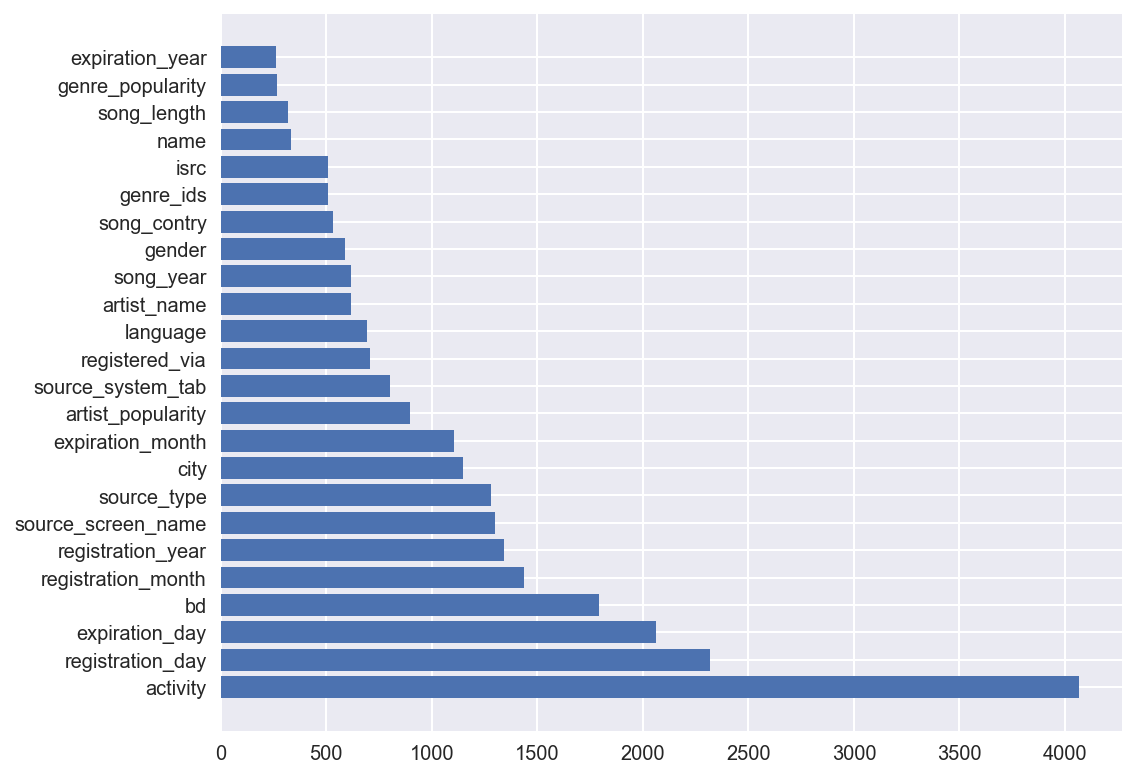

In [40]:
plot_feature_importance(model)

In [41]:
drop_01 = ["genre_popularity", "song_length", "expiration_year", "name"]

In [42]:
model = train_lgb(X_train_transformed.drop(drop_01, axis=1),
                  X_val_transformed.drop(drop_01, axis=1),
                  y_train, y_val, best_params)

[50]	training's auc: 0.750001	valid_1's auc: 0.747673
[100]	training's auc: 0.769513	valid_1's auc: 0.763665


Качество осталось на прежнем уровне (даже немного выросло), используем меньше фичей.

## SHAP

Пробовал делать `SHAP`, ноуту было тяжело, отказался от этой идеи.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

X_train_transformed = catboost_encoder.fit_transform(X_train, y_train)
X_test_transformed = catboost_encoder.transform(X_test)

model = train_lgb(X_train_transformed, X_test_transformed, y_train, y_test, best_params)

[50]	training's auc: 0.748539	valid_1's auc: 0.746867
[100]	training's auc: 0.768971	valid_1's auc: 0.764772


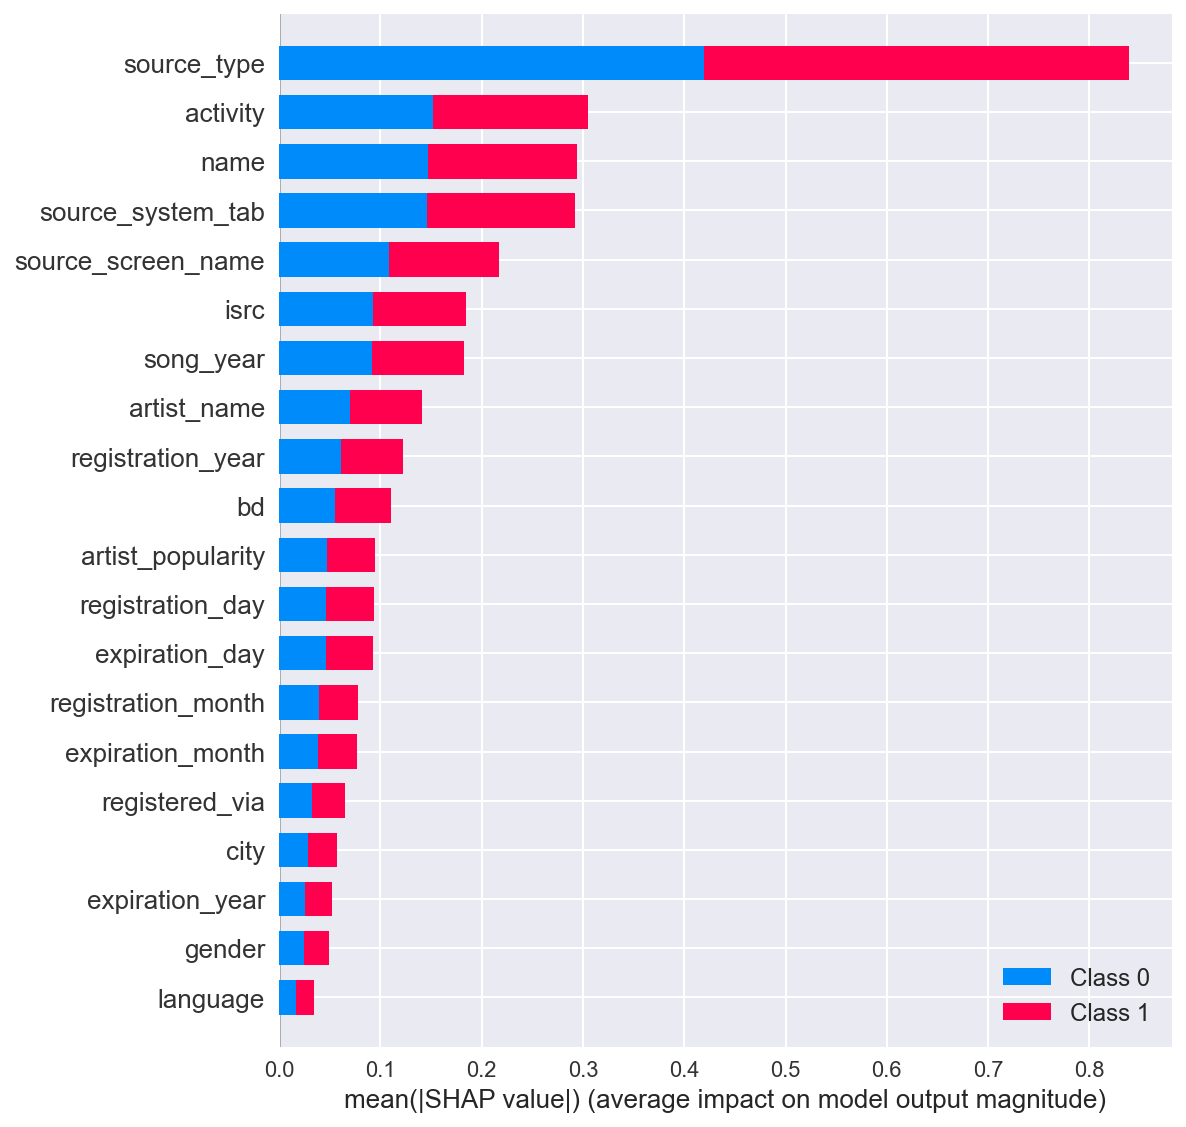

CPU times: user 2h 57min 12s, sys: 10.6 s, total: 2h 57min 23s
Wall time: 22min 48s


In [45]:
%%time
shap_values = shap.TreeExplainer(model).shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

Попробуем обучить без части фичей.

In [46]:
drop_shap = ["language", "gender", "expiration_year", "city"]

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_transformed = catboost_encoder.fit_transform(X_train, y_train)
X_val_transformed = catboost_encoder.transform(X_val)

In [48]:
model = train_lgb(X_train_transformed.drop(drop_shap, axis=1),
                  X_val_transformed.drop(drop_shap, axis=1),
                  y_train, y_val, best_params)

[50]	training's auc: 0.748156	valid_1's auc: 0.746053
[100]	training's auc: 0.76695	valid_1's auc: 0.761476


Качество немножко улучшилось. Выкидывать фичи не будем.

## K-Fold evaluation

In [53]:
def k_fold_evaluation(X: pd.DataFrame, y: pd.DataFrame, params,
                      k: int = 5, split_type: str = "simple"):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    kf = KFold(n_splits=k)
    
    if split_type == "simple":
        split = kf.split(X)
    elif split_type == "by_y":
        split = skf.split(X, y)
    elif split_type == "by_user":
        split = skf.split(X, train['msno'])
    else:
        raise ValueError
        
    start, end = '\033[92m', '\033[0m'
        
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(split):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                           random_state=1)
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1})
        lgb_val = lgb.Dataset(X_val, y_val, params={'verbose': -1})

        model = lgb.train(params, 
                          train_set=lgb_train, 
                          num_boost_round=100, 
                          verbose_eval=-1,
                          valid_sets=[lgb_train, lgb_val])
        
        roc_auc = roc_auc_score(y_test, model.predict(X_test))
        
        print(f"Fold {i + 1:>2}, ROC-AUC: {round(roc_auc, 5)}")
        roc_aucs.append(roc_auc)
        
    print(f"{start}Mean AUC_ROC: {np.mean(roc_aucs):.3f} with {k} folds{end}")

In [54]:
X_train_transformed = catboost_encoder.fit_transform(X, y)

Попробуем разные разбиения.

In [55]:
k_fold_evaluation(X_train_transformed, y, best_params)

Fold  1, ROC-AUC: 0.74645
Fold  2, ROC-AUC: 0.72895
Fold  3, ROC-AUC: 0.70667
Fold  4, ROC-AUC: 0.69002
Fold  5, ROC-AUC: 0.65537
Mean AUC_ROC: 0.705 with 5 folds


In [56]:
k_fold_evaluation(X_train_transformed, y, best_params, split_type="by_y")

Fold  1, ROC-AUC: 0.77419
Fold  2, ROC-AUC: 0.77448
Fold  3, ROC-AUC: 0.77439
Fold  4, ROC-AUC: 0.77155
Fold  5, ROC-AUC: 0.77399
Mean AUC_ROC: 0.774 with 5 folds


In [57]:
k_fold_evaluation(X_train_transformed, y, best_params, split_type="by_user")

Fold  1, ROC-AUC: 0.77426
Fold  2, ROC-AUC: 0.77313
Fold  3, ROC-AUC: 0.77476
Fold  4, ROC-AUC: 0.77439
Fold  5, ROC-AUC: 0.77538
Mean AUC_ROC: 0.774 with 5 folds


# Построение эмбеддингов

In [58]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
songs = pd.read_csv(os.path.join(data_path, "songs.csv"))
song_extra_info = pd.read_csv(os.path.join(data_path, "song_extra_info.csv"))

In [59]:
train = train.loc[:, ["msno", "song_id", "target"]]

In [60]:
songs = songs.merge(song_extra_info, on="song_id", how="left")

In [61]:
def join_names(x):
    return str(x["artist_name"]) + ' ' + str(x["name"])


songs["artist_song"] = songs[["artist_name", "name"]].apply(lambda x: join_names(x), axis=1)
songs = songs.loc[:, ["song_id", "artist_song"]]

In [62]:
train = train.merge(songs, on="song_id", how="left")
train_cache = deepcopy(train)

Рассмотрим те песни, которые слушали.

In [63]:
mask = train["target"] == 1
train = train.loc[mask, ["msno", "artist_song"]]

Если не сделать такую магию кодирования, то на построение корпуса уйдет больше часа. 

In [64]:
users = {user: i for i, user in enumerate(train["msno"].unique())}
songs = {song: j for j, song in enumerate(train["artist_song"].unique())}

train["msno"] = train["msno"].apply(lambda x: users[x])
train["artist_song"] = train["artist_song"].apply(lambda x: songs[x])

In [65]:
X = train.to_numpy()
corpus = [[str(x) for x in X[X[:, 0] == user][:, 1]] for user in tqdm(train["msno"].unique())]

100%|████████████████████████████████████| 27113/27113 [04:07<00:00, 109.57it/s]


Обучим `Word2Vec`.

In [66]:
model = Word2Vec(window=10,
                 vector_size=128,
                 negative=20,
                 min_count=1,
                 sg=0,
                 workers = multiprocessing.cpu_count())

model.build_vocab(corpus)

In [67]:
%%time
model.train(corpus, total_examples=model.corpus_count, epochs=100, report_delay=1)

CPU times: user 59min 14s, sys: 14.1 s, total: 59min 28s
Wall time: 8min 30s


(371304532, 371465600)

In [68]:
songs_inversed = {j: i for i, j in songs.items()}

def get_similars(code: str, num: int = 5):
    for sim in model.wv.most_similar(code)[:num]:
        print(f"Score: {sim[1]:.2f}, {songs_inversed[int(sim[0])]}")

Посмотрим на `Eminem`.

In [70]:
songs['Eminem The Kids']

78824

In [71]:
get_similars("78824")

Score: 0.72, Eminem Public Service Announcement 2000
Score: 0.71, Eminem Kim
Score: 0.71, Eminem Amityville
Score: 0.69, Eminem Criminal
Score: 0.69, TV & MOVIE SOUNDTRAX Big Girls Don't Cry (From "Mermaids")


Построим эмбеддинги для пользователей. Просто берем среднее по всем песням, которые слушал пользователь.

In [72]:
user_embedings = {}
for user, i in enumerate(train.msno.unique()):
    user_embedings[user] = np.array([model.wv[str(ii)] for ii in corpus[i]]).mean(axis=0)

В качестве нового признака добавим скоры от эмбеддингов.

In [73]:
scores = []

for row in train_cache.loc[:, ['msno', 'artist_song']].to_numpy():
    user, song = row
    score = 0
    
    if user in users and song in songs and users[user] in user_embedings and songs[song] in model.wv:
        score = np.sum(user_embedings[users[user]] * model.wv[songs[song]])
    
    scores.append(score)

In [74]:
train_cache["scores"] = scores

In [75]:
train = pd.read_csv('part_1.csv')
X, y = train.drop(columns=['target']), train['target']

X_train_transformed = catboost_encoder.fit_transform(X, y)

part_2 = pd.merge(X_train_transformed, train_cache.drop(["target", "artist_song"], axis=1),
                  how="left", left_on=['msno', 'song_id'], right_on = ['msno', 'song_id'])

X = part_2.drop(['msno', 'song_id'], axis=1)

In [76]:
k_fold_evaluation(X, y, best_params)

Fold  1, ROC-AUC: 0.76008
Fold  2, ROC-AUC: 0.74095
Fold  3, ROC-AUC: 0.71993
Fold  4, ROC-AUC: 0.70424
Fold  5, ROC-AUC: 0.67535
Mean AUC_ROC: 0.720 with 5 folds


In [77]:
k_fold_evaluation(X, y, best_params, split_type="by_y")

Fold  1, ROC-AUC: 0.784
Fold  2, ROC-AUC: 0.78382
Fold  3, ROC-AUC: 0.78531
Fold  4, ROC-AUC: 0.7863
Fold  5, ROC-AUC: 0.78419
Mean AUC_ROC: 0.785 with 5 folds


In [78]:
k_fold_evaluation(X, y, best_params, split_type="by_user")

Fold  1, ROC-AUC: 0.78556
Fold  2, ROC-AUC: 0.78243
Fold  3, ROC-AUC: 0.78516
Fold  4, ROC-AUC: 0.78484
Fold  5, ROC-AUC: 0.78505
Mean AUC_ROC: 0.785 with 5 folds


Добавление новых фичей помогло улучшить качество.